In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import numpy as np

# Generate theta and calculate y = sin(theta)
def generate_theta(num_elements):
    theta = np.linspace(0, np.pi/2, num_elements)
    return theta

def calculate_sin(theta):
    y = np.sin(theta)
    return y

# Calculate second derivative using central difference
def central_difference_second_derivative(y, theta, h):
    y_double_prime = np.zeros_like(y)

    for i in range(1, len(y) - 1):
        y_double_prime[i] = (y[i+1] - 2*y[i] + y[i-1]) / h**2

    return y_double_prime

# Calculate midpoints and errors
def calculate_x_with_max_error(theta, y):
    # x = arccos(m) is the point with max error
    x_with_max_error = np.zeros(len(y)-1)
    for i in range(1, len(y)):
        slope = (y[i] - y[i-1]) / (theta[i] - theta[i-1])
        x_with_max_error[i-1] = np.arccos(slope)

    interpolated_y = y[:-1] + (y[1:] - y[:-1]) / (theta[1:] - theta[:-1]) * (x_with_max_error - theta[:-1])
    actual_y = np.sin(x_with_max_error)
    errors = np.abs(actual_y - interpolated_y)

    # Find the index of the maximum error
    max_error_index = np.argmax(errors)
    max_error = errors[max_error_index]

    # Find the corresponding theta pair
    theta_pairs = [(theta[i], theta[i+1]) for i in range(len(theta) - 1)]
    max_error_theta_pair = theta_pairs[max_error_index]

    return max_error, errors, max_error_theta_pair


# Main function to adjust num_elements based on tolerance with adaptive step size
def optimize_elements(tolerance):
    num_elements = 10  # Initial guess for number of elements
    max_iterations = 100  # Max number of iterations to avoid infinite loop
    iteration = 0

    while iteration < max_iterations:
        theta = generate_theta(num_elements)
        y = calculate_sin(theta)

        # Calculate the second derivative
        y_double_prime = central_difference_second_derivative(y, theta, theta[1] - theta[0])

        # Calculate errors and get the max error
        max_error, errors, max_error_theta_pair = calculate_x_with_max_error(theta, y)

        # Adaptive step size calculation
        error_ratio = max_error / tolerance
        print(f"Iteration {iteration}: num_elements = {num_elements}, max_error = {max_error}")

        if max_error > tolerance:
            # Increase num_elements based on how large the error is compared to the tolerance
            step_size = int(num_elements * error_ratio * 0.5)  # Adjust the scaling factor as needed
            num_elements += max(1, step_size)  # Ensure at least 1 element is added
        elif max_error < tolerance * 0.5:
            # Decrease num_elements based on how far below the tolerance the error is
            step_size = int(num_elements * (1 - error_ratio) * 0.5)  # Adjust scaling factor
            num_elements -= max(1, step_size)  # Ensure at least 1 element is subtracted
        else:
            # If within acceptable tolerance, break
            break

        # Avoid going below 5 elements
        if num_elements < 5:
            num_elements = 5
            break

        iteration += 1  # Increment iteration count

    if iteration == max_iterations:
        print("Max iterations reached. The solution may not have converged.")

    # Once converged, find the max absolute second derivative
    max_second_derivative = np.max(np.abs(y_double_prime))
    corresponding_angle = theta[np.argmax(np.abs(y_double_prime))]

    # Print results
    print(f"For num_elements = {num_elements}:")
    print(f"Max error = {max_error:.6f}, between = {max_error_theta_pair}")
    print(f"Max second derivative = {max_second_derivative:.6f} at theta = {corresponding_angle:.4f}")

    return num_elements, max_error, max_second_derivative, y_double_prime, corresponding_angle


In [3]:
def refine_theta_based_on_second_derivative_and_tolerance(theta, y, max_second_derivative_original, tolerance):
    new_theta = np.copy(theta)  # Create a copy of theta to modify
    new_y = np.copy(y)          # Copy y as well for calculations
    h = theta[1] - theta[0]
    len_of_new_theta = len(new_theta)

    for i in range(1, len_of_new_theta - 1):  # Iterate from 1 to len(new_theta) - 2
        # Temporarily remove the element at index i
        if(i >= len(new_theta)-1):
            break
        temp_theta = np.delete(new_theta, i)
        temp_y = np.sin(temp_theta)

        # Calculate the second derivative for the modified theta
        y_double_prime = non_uniform_central_difference_second_derivative(temp_y, temp_theta)
        max_error, errors, max_error_theta_pair = calculate_x_with_max_error(temp_theta, temp_y)

        # Find the max absolute second derivative in the updated array
        max_second_derivative = np.max(np.abs(y_double_prime))

        # Compare with the original max second derivative
        if max_second_derivative <= max_second_derivative_original or True:
            # Keep the element removed if the new max second derivative and new max error is smaller
            if max_error <= tolerance:
              new_theta = temp_theta  # Update new_theta permanently
              new_y = temp_y          # Update new_y permanently
              len_of_new_theta = len(new_theta)
        else:
            # If the new max is larger, restore the removed element by skipping to next
            continue

    return new_theta, new_y


In [4]:
def non_uniform_central_difference_second_derivative(y, theta):
    y_double_prime = np.zeros_like(y)

    for i in range(1, len(y) - 1):
        h1 = theta[i] - theta[i-1]  # Spacing between theta[i] and theta[i-1]
        h2 = theta[i+1] - theta[i]  # Spacing between theta[i+1] and theta[i]

        # Second derivative using non-uniform central difference formula
        y_double_prime[i] = (2 / (h1 + h2)) * ((y[i+1] - y[i]) / h2 - (y[i] - y[i-1]) / h1)

    return y_double_prime

In [5]:
# Get tolerance from user and run the optimization
tolerance = 0.0005  # float(input("Enter the tolerance value: "))

# Example usage after running optimize_elements
num_elements, max_error, max_second_derivative_original, y_double_prime, corresponding_angle = optimize_elements(tolerance)
theta = generate_theta(num_elements)
y = calculate_sin(theta)

# Refine theta based on second derivative
new_theta, new_y = refine_theta_based_on_second_derivative_and_tolerance(theta, y, max_second_derivative_original, tolerance)
new_theta, new_y, len(new_theta)

Iteration 0: num_elements = 10, max_error = 0.0037908277228748677
Iteration 1: num_elements = 47, max_error = 0.00014573378653603974
Iteration 2: num_elements = 31, max_error = 0.0003425576027423771
For num_elements = 31:
Max error = 0.000343, between = (1.5184364492350666, 1.5707963267948966)
Max second derivative = 0.998401 at theta = 1.5184


(array([0.        , 0.10471976, 0.20943951, 0.31415927, 0.41887902,
        0.4712389 , 0.52359878, 0.57595865, 0.62831853, 0.68067841,
        0.73303829, 0.78539816, 0.83775804, 0.89011792, 0.9424778 ,
        0.99483767, 1.04719755, 1.09955743, 1.15191731, 1.20427718,
        1.25663706, 1.30899694, 1.36135682, 1.41371669, 1.46607657,
        1.51843645, 1.57079633]),
 array([0.        , 0.10452846, 0.20791169, 0.30901699, 0.40673664,
        0.4539905 , 0.5       , 0.54463904, 0.58778525, 0.62932039,
        0.66913061, 0.70710678, 0.74314483, 0.77714596, 0.80901699,
        0.83867057, 0.8660254 , 0.89100652, 0.91354546, 0.93358043,
        0.95105652, 0.96592583, 0.9781476 , 0.98768834, 0.9945219 ,
        0.99862953, 1.        ]),
 27)

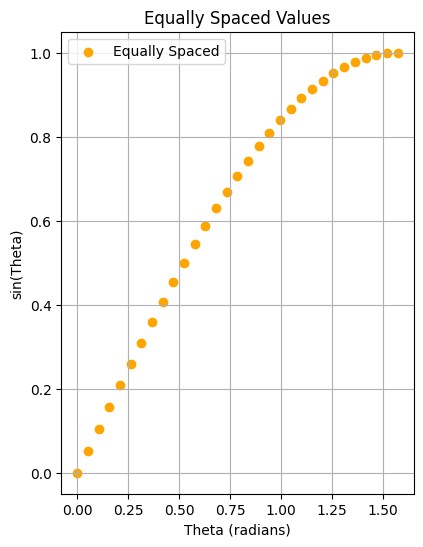

In [6]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot equally spaced values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(theta, y, color='orange', label='Equally Spaced')
plt.title('Equally Spaced Values')
plt.xlabel('Theta (radians)')
plt.ylabel('sin(Theta)')
plt.grid()
plt.legend()

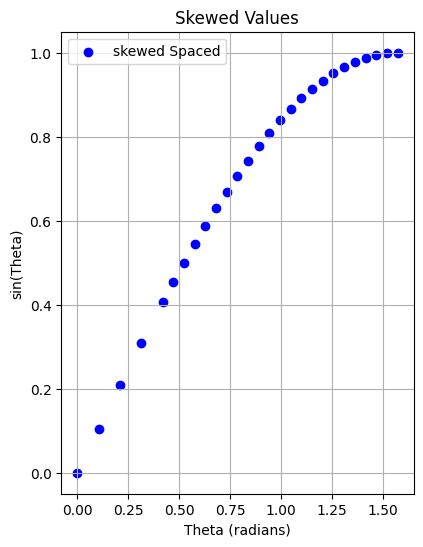

In [7]:
# Create the figure and axis
plt.figure(figsize=(10, 6))

# Plot equally spaced values
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(new_theta, new_y, color='blue', label='skewed Spaced')
plt.title('Skewed Values')
plt.xlabel('Theta (radians)')
plt.ylabel('sin(Theta)')
plt.grid()
plt.legend()

In [8]:
# Function to perform linear interpolation using central difference
def linear_interpolation(x, y, angle):
    neg_side = 1
    # When angle is greater than 360, find angle % 360
    if angle > 4*x[-1]:
        angle = angle%(4*x[-1])
    # When angle is negative, sin(-x) = -sin(x)
    elif angle < 0:
        angle = -1 * angle
        neg_side = -1

    # When angle between 0 and 90 degree, return sin(angle)
    if angle >= x[0] and angle <= x[-1]:
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    # When angle between 90 and 180, return sin(180 - angle)
    elif angle > x[-1] and angle <= 2*x[-1]:
        angle = 2*x[-1] - angle
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    # When angle between 180 and 270, return -sin(angle)
    elif angle > 2*x[-1] and angle <= 3*x[-1]:
        angle = angle - 2*x[-1]
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return -1 * neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    # When angle between 180 and 360, return -sin(360 - angle)
    elif angle > 3*x[-1] and angle <= 4*x[-1]:
        angle = 4*x[-1] - angle
        for i in range(len(x) - 1):
            if x[i] <= angle <= x[i + 1]:
                return -1 * neg_side * (y[i] + (angle - x[i]) * (y[i + 1] - y[i]) / (x[i + 1] - x[i]))
    else:
        return None  # Unexpected value

In [9]:
# Function to find sine value and perform interpolation if necessary
def get_sine_value(angle, theta, sine):
    sine_value = linear_interpolation(theta, sine, angle)
    actual_value = np.sin(angle)

    error = actual_value - sine_value if sine_value is not None else None
    relative_error = error / actual_value if error is not None and actual_value != 0 else None

    return {
        'Angle': angle*180/np.pi,
        'Sine Approx': sine_value,
        'Error': error,
        'Relative Error': relative_error,
        'Actual Sine': actual_value
    }

In [10]:
test_angles = np.random.uniform(0, 200*np.pi, 100)
test_angles = [angle for angle in test_angles]

In [11]:
# Calculate results for the entered test angles
results = []
for angle in test_angles:
    result = get_sine_value(angle, new_theta, new_y)
    results.append(result)

# Create a DataFrame for results
results_df = pd.DataFrame(results)
results_df

,Angle,Sine Approx,Error,Relative Error,Actual Sine
0,30963.162826,0.055101,0.000073,0.001320,0.055174
1,2270.600722,0.935906,0.000149,0.000159,0.936055
2,11874.191608,-0.101190,-0.000012,0.000115,-0.101202
3,14867.341019,0.954323,0.000225,0.000236,0.954548
4,28782.621738,-0.298540,-0.000139,0.000464,-0.298679
...,...,...,...,...,...
95,15577.504891,0.991094,0.000340,0.000343,0.991434
96,17415.566605,0.699934,0.000145,0.000208,0.700080
97,22029.176264,0.934607,0.000071,0.000076,0.934678
98,18969.805358,-0.938272,-0.000253,0.000270,-0.938525


In [13]:
# check if all errors are within the tolerance
if np.all(results_df['Error'].abs() <= tolerance):
    print("All errors are within the tolerance.")
else:
    print("Errors are outside the tolerance.")

All errors are within the tolerance.
